### Notebook of miscellaneous data exploration that did not need to be included in main notebook

###### Importing necessary tools, loading dataset, and preprocessing the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv('data/dataset-of-10s.csv')

###### Additional exploration of data features:

In [3]:
data['mode'][data['target']==1].sum()

2114

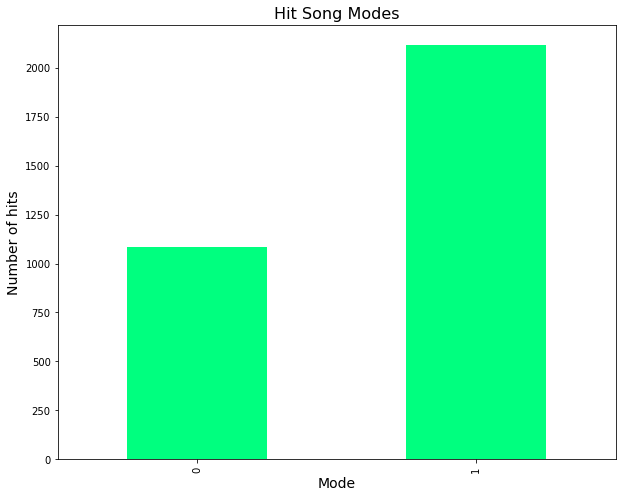

In [4]:
# Mode bar plot (number of hits in major vs. minor)
major_minor = data.groupby('mode')['target'].sum()
major_minor.plot(kind='bar', figsize=(10,8), color='springgreen')
plt.title('Hit Song Modes', fontsize=16)
plt.xlabel('Mode', fontsize=14)
plt.ylabel('Number of hits', fontsize=14);



In [5]:
major = (2114/3199)*100
minor = 100-((2268/3199)*100)
print("Major:", major, "Minor:", minor)

Major: 66.08315098468272 Minor: 29.102844638949676


Of the songs that were a hit, about 66.08% were major and about 29.10% were minor.

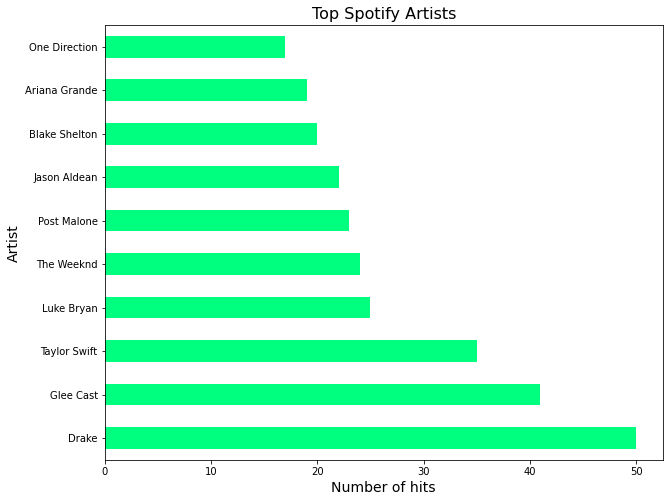

In [6]:
# bar plot of artist with the most hit songs (top artists)

top_artists = data.groupby('artist')['target'].sum().sort_values(ascending=False).nlargest(10)
top_artists.plot(kind='barh', figsize=(10,8), color='springgreen')
plt.title('Top Spotify Artists', fontsize=16)
plt.xlabel('Number of hits', fontsize=14)
plt.ylabel('Artist', fontsize=14);


In [7]:
data.groupby('artist')['target'].sum().sort_values(ascending=False).nlargest(10).sum()

276

In [8]:
(276/3199)*100

8.627696155048453

The top 10 artists in this dataset with the most hit songs are Drake, Glee Cast, Taylor Swift, Luke Bryan, The Weeknd, Post Malone, Jason Aldean, Blake Shelton, Ariana Grande, and One Direction. Together, these artists have about 8.63% of the hit songs in this particular dataset.

###### Trying other models for baseline (KNN, logistic regression):

In [9]:
X = data.drop(columns=['target', 'uri', 'artist', 'track'], axis=1)
y = data['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

In [10]:
X_train = X_train.apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)

X_test = X_test.apply(lambda x : (x - x.min()) /(x.max() - x.min()), axis=0)



In [11]:
knn_model = KNeighborsClassifier()

knn_model.fit(X_train, y_train)

train_preds = knn_model.predict(X_train)
test_preds = knn_model.predict(X_test)


In [12]:
print("Training Precision Score for KNN Classifier: {:.4}%".format(precision_score(y_train, train_preds) * 100))
print("Testing Precision Score for KNN Classifier: {:.4}%".format(precision_score(y_test, test_preds) * 100))

print("Training Accuracy Score for KNN Classifier: {:.4}%".format(accuracy_score(y_train, train_preds) * 100))
print("Testing Accuracy Score for KNN Classifier: {:.4}%".format(accuracy_score(y_test, test_preds) * 100))

Training Precision Score for KNN Classifier: 79.33%
Testing Precision Score for KNN Classifier: 72.93%
Training Accuracy Score for KNN Classifier: 84.22%
Testing Accuracy Score for KNN Classifier: 76.69%


In [13]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

model_log = logreg.fit(X_train, y_train)

y_hat_train_log = logreg.predict(X_train)
y_hat_test_log = logreg.predict(X_test)


In [14]:
print("Training precision score for logistic regression model: {:.4}%".format(precision_score(y_train, y_hat_train_log) * 100))
print("Testing precision score logistic regression model: {:.4}%".format(precision_score(y_test, y_hat_test_log) * 100))

print("Training accuracy score logistic regression model: {:.4}%".format(accuracy_score(y_train, y_hat_train_log)* 100))
print("Testing accuracy score logistic regression model:{:.4}%".format(accuracy_score(y_test, y_hat_test_log)* 100))

Training precision score for logistic regression model: 73.34%
Testing precision score logistic regression model: 80.1%
Training accuracy score logistic regression model: 78.68%
Testing accuracy score logistic regression model:65.75%


###### Choosing baseline model interpretation:
Of these three types of models (decision tree, KNN classifier, and logistic regression), the decision tree has the highest testing accuracy and precision. While the KNN model has the highest training accuracy and precision, it also seems to have the most overfitting.
Therefore, the decision tree wil be used as the baseline model.

#### Trying out various different parameters for GridSearchCV (baseline dt):

In [15]:
baseline_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
baseline_tree.fit(X_train, y_train)
y_hat_train = baseline_tree.predict(X_train)
y_hat_test = baseline_tree.predict(X_test)


In [16]:
dt_param_grid ={
    "criterion": ["gini", "entropy"],
    "max_depth": [None,5,10],
    "min_samples_split": [0.2, 0.4, 0.6],
    "max_features": [5, 10, 15],
    'min_samples_leaf': [2, 4, 6, 8]
    
    
}
# Options: max. depth, min. samples split, min. leaf sample size, max. leaf nodes, max. features 


In [17]:
dt_grid_search = GridSearchCV(baseline_tree , dt_param_grid, cv=3, return_train_score=True)

dt_grid_search.fit(X_train, y_train)

# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_["mean_train_score"])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Mean Training Score: 79.71%
Mean Test Score: 77.56%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 5,
 'min_samples_leaf': 8,
 'min_samples_split': 0.6}

In [18]:
dt_param_grid2 ={
    "max_depth": [8, 10, 12],
    "min_samples_split": [0.1, 0.2, 0.3],
    "max_features": [8, 10, 12],
    'min_samples_leaf': [3, 4, 5],
    
    
}
# Options: criterion, max. depth, min. samples split, min. leaf sample size, max. leaf nodes, max. features 


In [19]:
dt_grid_search2 = GridSearchCV(baseline_tree , dt_param_grid2, cv=3, return_train_score=True)

dt_grid_search2.fit(X_train, y_train)

# Mean training score
dt_gs_training_score2 = np.mean(dt_grid_search2.cv_results_["mean_train_score"])

# Mean test score
dt_gs_testing_score2 = dt_grid_search2.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score2 :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score2 :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search2.best_params_

Mean Training Score: 80.65%
Mean Test Score: 78.00%
Best Parameter Combination Found During Grid Search:


{'max_depth': 10,
 'max_features': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 0.2}

In [20]:
dt_param_grid3 ={
    "max_depth": [None,5,10],
    "max_features": [5, 10, 15],
    'min_samples_leaf': [4, 6, 8, 10],
    "min_samples_split": [ 0.2, 0.4, 0.6],
    
}
# Options: max. depth, min. samples split, min. leaf sample size, max. leaf nodes, max. features 


In [21]:
dt_grid_search3 = GridSearchCV(baseline_tree , dt_param_grid3, cv=3, return_train_score=True)

dt_grid_search3.fit(X_train, y_train)

# Mean training score
dt_gs_training_score3 = np.mean(dt_grid_search3.cv_results_["mean_train_score"])

# Mean test score
dt_gs_testing_score3 = dt_grid_search3.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score3 :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score3 :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search3.best_params_

Mean Training Score: 79.68%
Mean Test Score: 78.25%
Best Parameter Combination Found During Grid Search:


{'max_depth': 5,
 'max_features': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 0.6}

In [22]:
# Train a classifier with optimal values identified above
dt = DecisionTreeClassifier(
                            max_depth=5,
                            min_samples_leaf=6,
                            max_features = 5,
                            random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8010308601752322

In [23]:
dt = DecisionTreeClassifier(
                            max_depth=3,
                            min_samples_leaf=4,
                            max_features = 10,
                            min_samples_split = 0.2,
                            random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7788393173852373

#### Trying out various different parameters for GridSearchCV (random forests model):

In [24]:
forest = RandomForestClassifier(max_features='sqrt',
                               max_samples = 0.5,
                               random_state=42)
forest.fit(X_train, y_train)

y_hat_train3 = forest.predict(X_train)
y_hat_test3 = forest.predict(X_test)


In [25]:
rf_param_grid = {
    "max_depth": [5, 7, 10],
    "max_features": [5, 10, 15],
    'min_samples_leaf': [4, 6, 8, 10],
    "min_samples_split": [ 0.2, 0.4, 0.6],
}


In [26]:
rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 82.20%

Optimal Parameters: {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 0.2}


In [27]:
rf_param_grid2 = {
    "max_depth": [None, 5],
    "max_features": [5, 7, 10],
    'min_samples_leaf': [4, 6, 8, 10]
}


In [28]:
rf_grid_search2 = GridSearchCV(forest, rf_param_grid2, cv=3)
rf_grid_search2.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search2.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search2.best_params_}")

Testing Accuracy: 84.41%

Optimal Parameters: {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 6}


In [29]:
rf = RandomForestClassifier(max_depth=None,
                            max_features = 10,
                            min_samples_leaf= 6,
                            random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8064719017549782

In [30]:
# Which model performed best on the test set?
dt_score = dt_grid_search.score(X_test, y_test)
rf_score = rf_grid_search.score(X_test, y_test)

print("Decision tree grid search: ", dt_score)
print("Random forest grid search: ", rf_score)

Decision tree grid search:  0.775625
Random forest grid search:  0.798125


The GridSearch for this random forests model also performed better than the one for our baseline decision tree model.